# Attention Is All You Need


_This notebook demonstrates the implementation of Transformers architecture proposed by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762) for neural machine translation (NMT)._


> _Sequence-to-sequence models are deep learning models that have achieved a lot of success in tasks like machine translation, text summarization, and image captioning. Google Translate started [using](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/) such a model in production in late 2016. These models are explained in the two pioneering papers ([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf), [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)). (Excerpt from a [blog post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) by Jay Alammar)_

Sequence-to-sequence (aka seq2seq) model is an end-to-end deep learning model which transforms one sequence to another. It consists of two recurrent neural networks:
- encoder, which encodes an input sequence of variable size into a context vector of fixed size
- decoder, which unfolds the context vector into a new sequence (output).


![seq2seq model](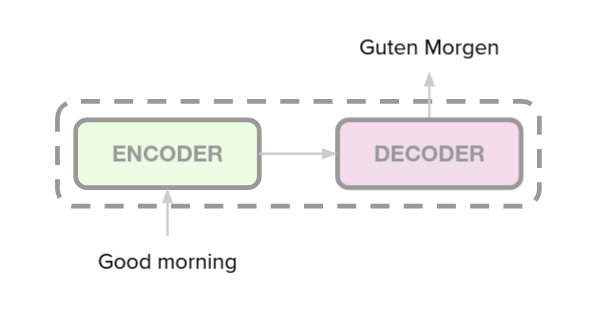 "Seq2Seq Model")


Seq2Seq NMT model can be thought of autoregressive language model where the decoder finds the target sequence that is the most probable conditioned on the input sequence. Mathematically, it can be formulated as follows:

$$
P(y|x) = P(y_1|x) P(y_2|y_1,x) \dots P(y_T|y_1, \dots, y_{T-1}, x)
$$

where $x$ is the input sequence and $y$ is the output sequence.


Attention mechanism have overcomed the drawback of vanilla seq2seq models by providing us a way to see different parts of encoder outputs during the decoding stage, which allows us to preserve the context. The attention mechanim between encoder and decoder resulted in performance improvements for machine translation task.

Transformer are a class of deep learning models which does not use any recurrence. Instead they use self-attention mechanism for representations to find global dependencies between input and target. Transformers have become the de facto standard in NLP and have achieved state-of-the-art performance for various tasks. The Transformer is behind all the popular language models such as BERT, GPT, etc.


We will build a Transformer model for English to German translation using PyTorch.


In [1]:

# download the spacy language models for english and german
!python -m spacy download en --quiet
!python -m spacy download de --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


## Imports


In [83]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [84]:
# plot style configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

In [85]:
# for reproducibility
# refer https://pytorch.org/docs/stable/notes/randomness.html
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [86]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing and Loading


In [87]:
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

def tokenize_en(text):
    """ Translates english text sequence into a list of tokens.
    """
    return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_de(text):
    """ Translates german text sequence into a list of tokens.
    """
    return [token.text for token in spacy_de.tokenizer(text)]

PAD_TOKEN = '<pad>'
SOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'
UNK_TOKEN = '<unk>'

# english text field
en_text = Field(
    tokenize=tokenize_en, lower=True, include_lengths=True, batch_first=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

# german text field
de_text = Field(
    tokenize=tokenize_de, lower=True, include_lengths=True, batch_first=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

In [88]:
data_fields = (('src', en_text), ('trg', de_text))

train_data, valid_data, test_data = Multi30k.splits(
    exts=('.en', '.de'), fields=data_fields
)

In [89]:
# build the english and german vocabulary
en_text.build_vocab(train_data.src, max_size=10000, min_freq=2)
de_text.build_vocab(train_data.trg, max_size=10000, min_freq=2)

In [90]:
PAD_IDX = de_text.vocab.stoi[PAD_TOKEN]
SOS_IDX = de_text.vocab.stoi[SOS_TOKEN]
EOS_IDX = de_text.vocab.stoi[EOS_TOKEN]
UNK_IDX = de_text.vocab.stoi[UNK_TOKEN]

print(f'English vocabulary: {len(en_text.vocab)} words')
print(f'German vocabulary: {len(de_text.vocab)} words')

English vocabulary: 5893 words
German vocabulary: 7853 words


In [91]:
import itertools

# Frequencies corresponding to each word in english
list(itertools.islice(en_text.vocab.freqs.items(), 10))


[('two', 3886),
 ('young', 2280),
 (',', 3963),
 ('white', 2238),
 ('males', 40),
 ('are', 3717),
 ('outside', 871),
 ('near', 571),
 ('many', 222),
 ('bushes', 19)]

In [92]:
# Id's corresponding to each word in english
list(itertools.islice(en_text.vocab.stoi.items(), 10))

[('<unk>', 0),
 ('<pad>', 1),
 ('<s>', 2),
 ('</s>', 3),
 ('a', 4),
 ('.', 5),
 ('in', 6),
 ('the', 7),
 ('on', 8),
 ('man', 9)]

In [93]:
print(f'# of training examples: {len(train_data.examples)}')
print(f'# of validation examples: {len(valid_data.examples)}')
print(f'# of testing examples: {len(test_data.examples)}')

print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

# of training examples: 29000
# of validation examples: 1014
# of testing examples: 1000
dict_keys(['src', 'trg'])
dict_values([['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']])


In [94]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

In [95]:
print(PAD_IDX)
print(SOS_IDX)
print(EOS_IDX)
print(UNK_IDX)

1
2
3
0


In [96]:
# sanity check to see if data loader is working
iterator = iter(train_iterator)
x = next(iterator)

print({'source': x.src[0].shape, 'source_lengths': x.src[1].shape})
print({'target': x.trg[0].shape, 'target_lengths': x.trg[1].shape})

{'source': torch.Size([64, 16]), 'source_lengths': torch.Size([64])}
{'target': torch.Size([64, 22]), 'target_lengths': torch.Size([64])}


In [50]:
# Every sentence is padded with SOS_IDX(2) at start and EOS_IDX(3) at end

print(x.src[0][0])
print(x.src[0][0].shape)
for id in x.src[0][0]:
    print(en_text.vocab.itos[id]+" ",end='')

tensor([   2,    4,   14, 4728, 5322,    8,    7,  349,   11,  418,    5,    3],
       device='cuda:1')
torch.Size([12])
<s> a woman busily multitasking on the phone and computer . </s> 

In [51]:
print(x.src[0][1])
print(x.src[0][1].shape)
for id in x.src[0][1]:
    print(en_text.vocab.itos[id]+" ",end='')

tensor([  2,   4,  55, 137,  13,   4, 223,   6,   7,  96,   5,   3],
       device='cuda:1')
torch.Size([12])
<s> a child plays with a toy in the grass . </s> 

In [52]:
# Every batch has same shape of source sentence lengths, if not they will be padded with PAD_IDX(1)
# Every batch has same shape of target sentence lengths, if not they will be padded with PAD_IDX(1)

print(x.src[0][-1])
print(x.src[0][-1].shape)
for id in x.src[0][-1]:
    print(en_text.vocab.itos[id]+" ",end='')

tensor([   2,   16,   30,  100,    6,   21,  736,  253, 1028,    5,    3,    1],
       device='cuda:1')
torch.Size([12])
<s> two men stand in an electric outdoor lift . </s> <pad> 

In [15]:
x = next(iterator)

print({'source': x.src[0].shape, 'source_lengths': x.src[1].shape})
print({'target': x.trg[0].shape, 'target_lengths': x.trg[1].shape})

{'source': torch.Size([64, 11]), 'source_lengths': torch.Size([64])}
{'target': torch.Size([64, 17]), 'target_lengths': torch.Size([64])}


## Model Architecture


![transformer_model](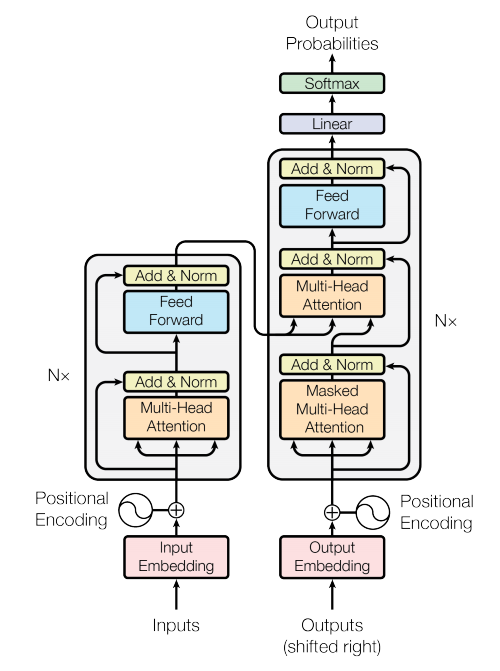 "Transformer Model")

(source: https://arxiv.org/pdf/1706.03762.pdf)


### Scaled Dot-Product Attention


![scaled_dot_product_attention](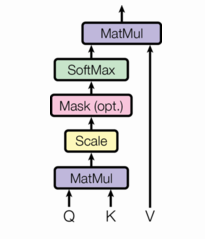 "Scaled Dot-Product Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


> _An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

The Transformer uses scaled dot-production attention as a self-attention block to compute the representations by taking the dot product of the query matrix $Q$ and the key matrix $K$ scaled by square root of head dimension ($\sqrt{d_k}$) followed by applying softmax and multiplying the values matrix $V$.

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
$$

The scaled dot-product attention is similar to standard dot-product (multiplicative) attention except that we use a scaling factor $\sqrt{d_k}$ in order to avoid extremely small gradients.

Scaled Dot-Product Attention returns the following:
- `output`: weighted sum of the values (self-attention representations) w.r.t alignment scores
- `attn_probs`: alignment scores indicating how well values around position $i$ match with values around position $j$


In [97]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate
        
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, key_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, key_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, key_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, key_len)
        
        # key_len = value_len
        # In self-attention query_len also equals key_len, but in attention its not equal

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

### Multi-Head Attention Module


![multi_head_attention](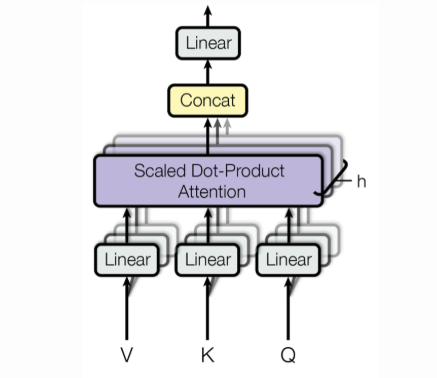 "Multi-Head Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


Instead of using single self-attention layer, the authors introduced multi-head attention mechanism which simply performs multiple scaled dot-product attention computations in parallel. The authors split queries, keys and values with $d_{model}$ dimension into $h$ heads and then re-combine scaled dot-product computation over each head into a single vector with $d_model$ dimension.

> _Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
W_i^Q \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^K \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^V \in \mathbb{R}^{\mathrm{d_{model}\times d_v}}, W_i^O \in \mathbb{R}^{\mathrm{hd_v\times d_{model}}}
$$

First, the inputs: query matrix $Q$, key matrix $K$ and value matrix $V$ are linearly projected using $W^Q$, $W^K$ and $W^V$. The projected query $QW^Q$, key $KW^K$ and value $VW^V$ are split into $h$ heads. Scaled dot-product attention is computed for each head $i$. The independent attention head computed are then concatenated and linearly projected using $W^O$.

Multi-Head Attention returns the following:
- `x`: context vector concatenated over all the attention heads
- `attn`: alignment scores (attention weights) over all the attention heads


In [98]:
class MultiHeadAttention(nn.Module):
    """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
        refer https://arxiv.org/abs/1706.03762
    """

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model  # input and output embed dim
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False) # Each W_i{Q} is d_model * d_k , W_q has weights of all 'h' W_i{Q}'s  
                                                           # weights(W_q) is d_model * d_model (d_k * h = d_model)
        self.W_k = nn.Linear(d_model, d_model, bias=False) # Same as above
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)
    

    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        # Q,K,V are inputs to SingleheadAttention
        
        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask
        
        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model) (n_head*head_dim = d_model)

        # apply linear projection to concatenated context vector(linear model is same for all tokens)
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # Take a specific sentence, for each token(query_len = #tokens) d_model is the dim of context vector


        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

### Position-wise Feed-Forward Network Module


This is the another block in the encoder as well as decoder layer which transforms from $d_{model}$ to $d_{ff}$ and then again to $d_{model}$. The same linear transformation is applied across different positions. This can also be viewed as two convolutions with filter size 1.

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

Position-wise Feed-Forward Network returns the following:
- `x`: non-linearity transformed vector of dimension same as input


In [99]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff) 
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)
    

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Positional Encoding Module


Since the transformer contains no recurrence and no convolutions, we need some way to inject information about relative or absolute position to assign order to tokens in the sequence. Sinusoidal positional encodings are used with different frequencies to unique represent the order and the position of the token in sequence.

$$
\begin{aligned}
\text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
\text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$

where $pos$ is the position and $i$ is the dimension.

> _We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

Positional Encoding Module returns the following:
- `x`: word embedding of the token in the sequence with inherent position information


In [100]:
class PositionalEncoding(nn.Module):
    """ Implements the sinusoidal positional encoding.
    """

    def __init__(self, d_model, dropout_rate=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.dropout = nn.Dropout(dropout_rate)
        
        # compute positional encodings
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model,)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(0), :]  # (batch_size, seq_len, d_model)
        x = self.dropout(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Encoder Module


The encoder consists of a stack of $N = 6$ identical layers, each containing two sub-layers, a multi-head self-attention layer, and a position-wise fully connected feed-forward network. Each sub-layer has a residual connection and layer normalization.

Encoder returns the following:
- `x`: encoded sequence representation using self-attention


In [101]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, mask)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [102]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    
    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)
        
        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, source_seq_len, d_model)
        
        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

### Decoder Module


The decoder is quite similar to the encoder, except that the decoder contains two multi-head self-attention layers instead of a single layer in a stack of $N = 6$ identical layers. The first multi-head self-attention layer attends to decoder outputs generated so far and is masked in order to prevent positions from attending to future positions, whereas the second multi-head self-attention layer attends over the encoder stack output.

Decoder returns the following:
- `x`: output sequence representation using self-attention
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [103]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention 
        layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)

    
    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model) # Encoder output
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, tgt_mask)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory, src_mask)

        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)
        
        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn # attn is attention between encoder_outputs and inputs of the current decoder layer

In [104]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    
    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask, tgt_mask)  # (batch_size, target_seq_len, d_model)
        
        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn  # attn is attention between encoder_outputs and inputs of the last decoder layer

### Transformer


The input and output sequences are embedded into a $d_{model}$ dimensional space, which is the usual step before feeding the sequence into the neural network. Positional encoding is also applied to the embedded sequence, which gives a sense of order in the sequence. Encoder encodes the input sequence and generates encoded representation using self-attention mechanism. The decoder uses this representation along with the sequence generated so far to compute the output sequence.

The Transformer returns the following:
- `output`: output sequence generated
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [105]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder.
    """

    def __init__(self, encoder, decoder, generator, pad_idx):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator

    
    def get_pad_mask(self, x, pad_idx):
        """ x: (batch_size, seq_len)
        """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)

        # x: (batch_size, 1, seq_len) 
        return x

    
    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len)
        """
        seq_len = x.size(1)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)  # (batch_size, seq_len, seq_len)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)  # (batch_size, seq_len, seq_len)


        # subsequent_mask: (batch_size, seq_len, seq_len)
        return subsequent_mask


    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
            tgt: (batch_size, target_seq_len)
        """
        # create masks for source and target
        src_mask = self.get_pad_mask(src, self.pad_idx)
        tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)

        # src_mask: (batch_size, 1, seq_len)
        # tgt_mask: (batch_size, seq_len, seq_len)

        # encode the source sequence
        enc_output = self.encoder(src, src_mask)  # (batch_size, source_seq_len, d_model)

        # decode based on source sequence and target sequence generated so far
        dec_output, attn = self.decoder(tgt, enc_output, src_mask, tgt_mask)

        # Note that dec_output[i,j,:] depends only on the enc_output and tgt[i,:j](This is ensured by means of tgt_mask)
        # (self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position)

        # dec_output: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply linear projection to obtain the output distribution
        output = self.generator(dec_output)  # (batch_size, target_seq_len, vocab_size)

        # Note that output[i,j,:] depends only on the enc_output and tgt[i,:j]
        # So output[i,j,:](probabilities) can be interpreted as distribution of (j+1)th word in the ith sequence

        # output: (batch_size, target_seq_len, vocab_size)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return output, attn  # attn is attention between encoder_outputs and inputs of the last decoder layer

### Masks in src and tgt sequences

In [57]:
# sanity check to see if data loader is working
iterator = iter(train_iterator)
x = next(iterator)
src = x.src[0][0]
tgt = x.trg[0][0]
print(src)
print(tgt)

tensor([   2,  113,   19,   17,  165,    4,  663,   28,    8,    4, 5653,  281,
           5,    3], device='cuda:1')
tensor([  2,  76,  73,  12,  14,   0, 167,   8, 662,   4,   3,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1], device='cuda:1')


In [68]:
def get_pad_mask(x, pad_idx):
        """ x: (batch_size, seq_len)
        """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)

        # x: (batch_size, 1, seq_len) 
        return x
def get_subsequent_mask(x):
        """ x: (batch_size, seq_len)
        """
        seq_len = x.size(0)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)  # (batch_size, seq_len, seq_len)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)  # (batch_size, seq_len, seq_len)


        # subsequent_mask: (batch_size, seq_len, seq_len)
        return subsequent_mask

In [80]:
# src mask, Attention of a word should not consider PAD_ID's
src_mask = get_pad_mask(src,PAD_IDX)
src_mask

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]], device='cuda:1')

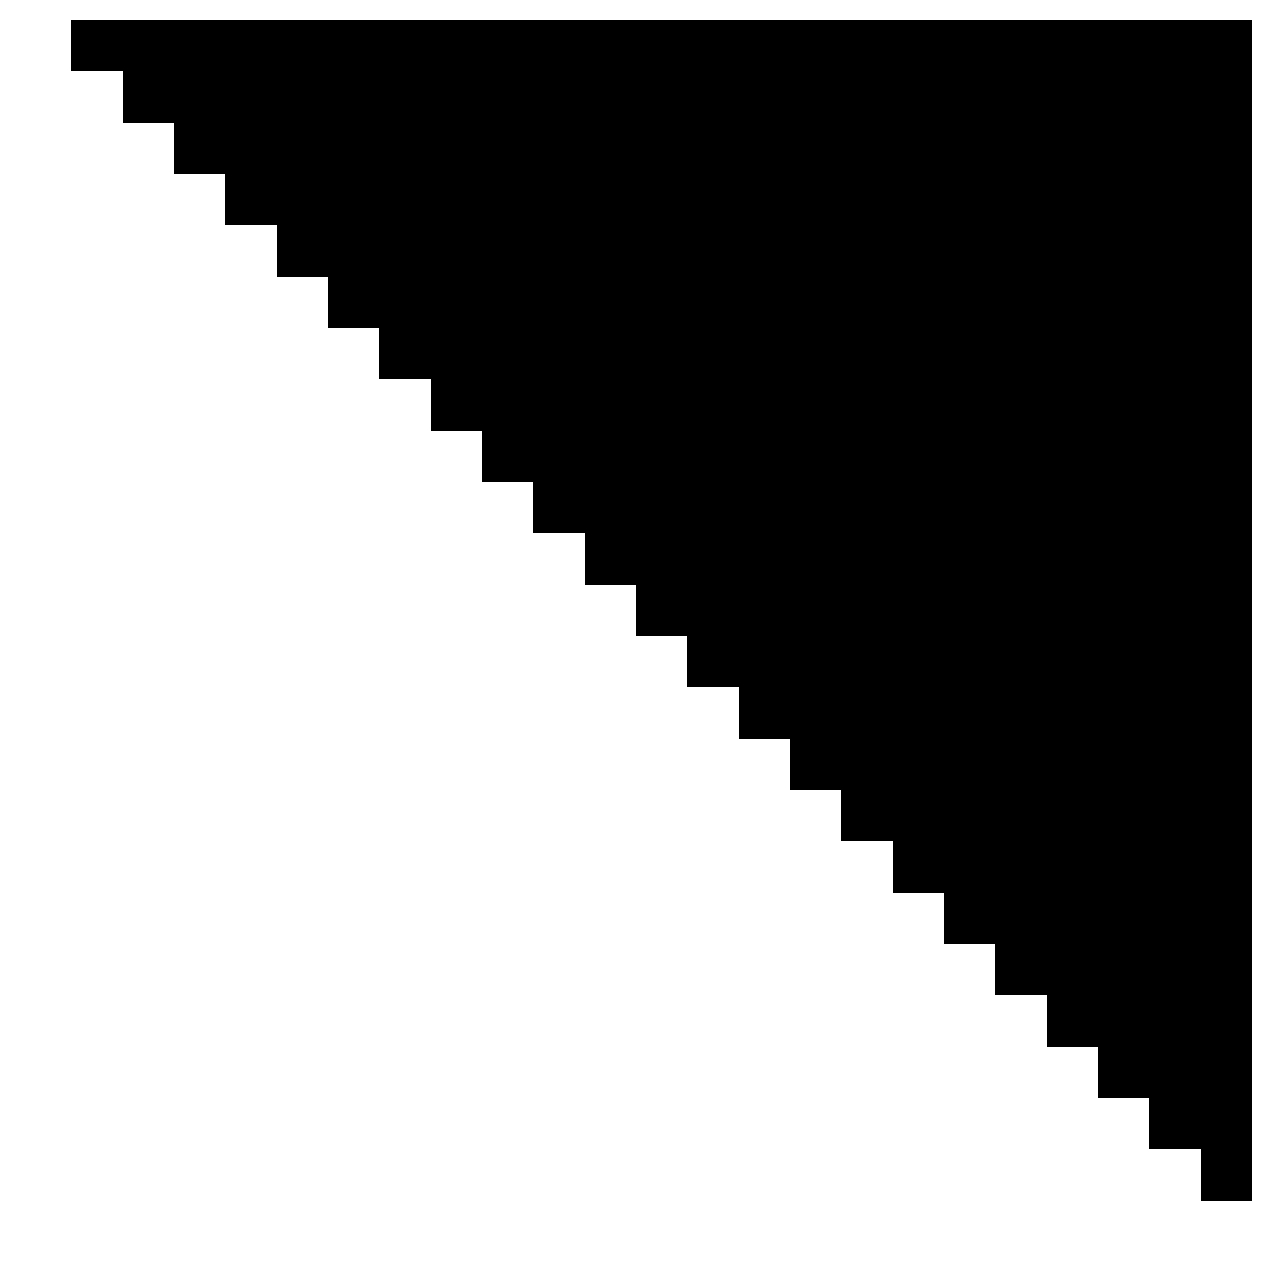

In [81]:
sub_tgt_mask = get_subsequent_mask(tgt)

import matplotlib.pyplot as plt

# Convert boolean values to integer (0 for False, 1 for True)
integer_tensor = sub_tgt_mask[0].cpu().numpy().astype(int)

# Display the tensor as an image
plt.imshow(integer_tensor, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

Calculate attention to only words to the left of a specific word in target seq. Technically a target word should not depend on future words(as we are generating words one by one from left).
We are using context vector corresponding to a target seq token as predicting for next token in target seq.(So a context vector should not depend on later tokens in target seq)
#### This is called Masked self attention

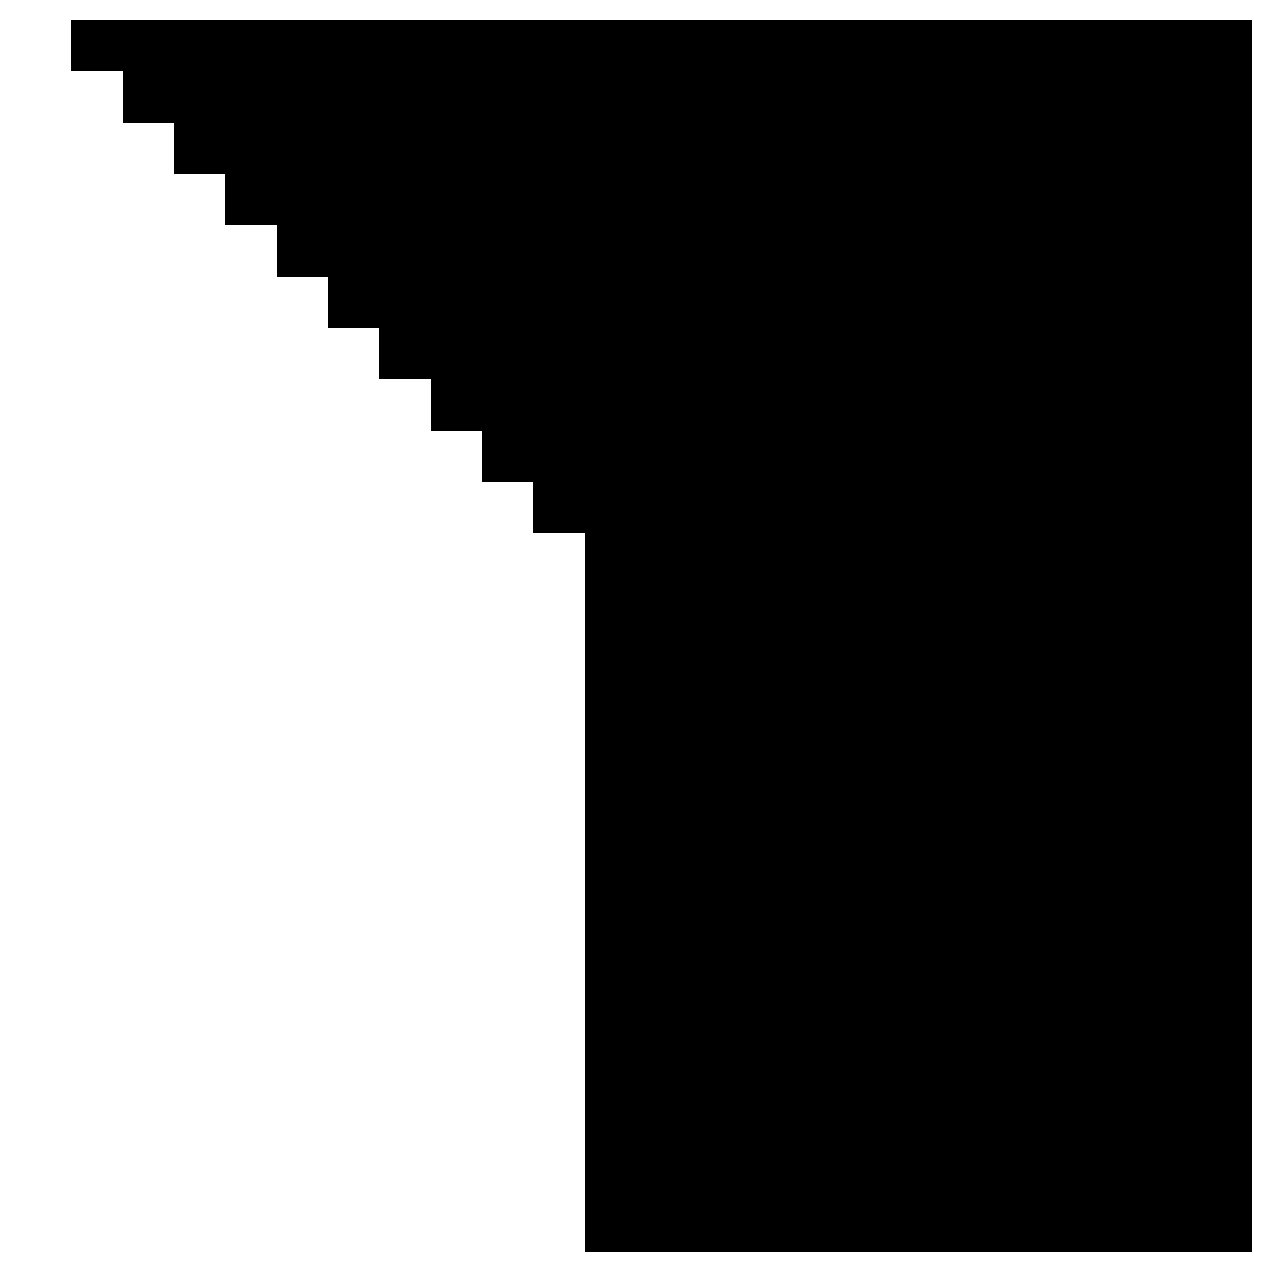

In [82]:
tgt_mask = get_pad_mask(tgt,PAD_IDX) & get_subsequent_mask(tgt)
# Convert boolean values to integer (0 for False, 1 for True)
integer_tensor = tgt_mask[0].cpu().numpy().astype(int)

# Display the tensor as an image
plt.imshow(integer_tensor, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In addition a word should not depend on PAD_ID(PAD_ID are used used just to ensure equal length sentences in a batch). At top tgt sentence has 11 PAD_ID's at end

In [106]:
class Generator(nn.Module):
    """ Linear projection layer for generating output distribution.
    """

    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)
    

    def forward(self, x):
        """ x: (batch_size, target_seq_len, d_model)
        """
        # apply linear projection followed by softmax to obtain output distribution
        x = self.proj(x)  # (batch_size, target_seq_len, vocab_size)
        output = F.log_softmax(x, dim=-1)  # (batch_size, target_seq_len,vocab_size)

        # output: (batch_size, target_seq_len, vocab_size)
        return output

## Helper Utilities


In [107]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [108]:
def convert_ids_to_text(ids, vocab, eos_idx, unk_idx):
    """ Converts token ids to text.
    """
    if ids.dim() == 1:
        output_tokens = []
        for token_id in ids:
            if token_id == eos_idx:
                break
            else:
                output_tokens.append(vocab.itos[token_id])
        return output_tokens
    
    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[i, :], vocab, eos_idx, unk_idx) for i in range(ids.size(0))]
    
    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

In [109]:
class NoamOptim(object):
    """ Optimizer wrapper for learning rate scheduling.
    """

    def __init__(self, optimizer, d_model, factor, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.factor = factor
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0
    

    def zero_grad(self):
        self.optimizer.zero_grad()


    def step(self):
        self.n_steps += 1
        lr = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.optimizer.step()

    
    def get_lr(self):
        return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

## Training


In [110]:
def train_fn(model, iterator, optimizer, critertion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        source, source_lengths = batch.src
        target, target_lengths = batch.trg

        # source: (batch_size, source_seq_len), source_lengths: (batch_size)
        # target: (batch_size, target_seq_len), target_lengths: (batch_size)
        
        # forward pass
        optimizer.zero_grad()
        output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

        # output[i,j,:] can be interpreted as distribution of (j+1)th word in the ith target
        # We are predicting the next word in the target sequence
        
        # calculate the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size) # Next predicted words distribution
            target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1)) # ground truth words
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()
        
        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    
    return output, perplexity

In [111]:
def eval_fn(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            source, source_lengths = batch.src
            target, target_lengths = batch.trg

            # source: (batch_size, source_seq_len), source_lengths: (batch_size)
            # target: (batch_size, target_seq_len), target_lengths: (batch_size)
            
            # forward pass
            optimizer.zero_grad()
            output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)
            
            # calculate the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
                target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
            )
            total_loss += loss.item()
            steps += 1

            output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)
            target = target[:, 1:]  # (batch_size, target_seq_len - 1)

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output, de_text.vocab, EOS_IDX, UNK_IDX)
            target_tokens = convert_ids_to_text(target, de_text.vocab, EOS_IDX, UNK_IDX)

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]

            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)
    
    return output, perplexity, bleu4

In [112]:
# hyperparameters
INPUT_SIZE = len(en_text.vocab)  # source vocab size
OUTPUT_SIZE = len(de_text.vocab)  # target vocab size
HIDDEN_SIZE = 512
N_LAYERS = 6
N_HEADS = 8
FF_SIZE = 2048
DROPOUT_RATE = 0.1
N_EPOCHS = 10
CLIP = 1.0

In [113]:
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
generator = Generator(HIDDEN_SIZE, OUTPUT_SIZE)

model = Transformer(encoder, decoder, generator, PAD_IDX).to(device)
model_summary(model)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5893, 512, padding_idx=1)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attn_layer): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=False)
          (W_k): Linear(in_features=512, out_features=512, bias=False)
          (W_v): Linear(in_features=512, out_features=512, bias=False)
          (W_o): Linear(in_features=512, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (attn_layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ff_layer): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inp

In [114]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9),
    model.encoder.d_model, 2, 4000
)

In [115]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [32]:
best_bleu4 = float('-inf')
es_patience = 3
patience = 0
model_path = 'model.pth'


for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    _, train_perplexity = train_fn(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    _, valid_perplexity, valid_bleu4 = eval_fn(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}')
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience += 1
        print(f'Early stopping counter: {patience} out of {es_patience}')
        if patience == es_patience:
            print(f'Early stopping! Best BLEU4: {best_bleu4:.4f}')
            break

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0, Train perplexity: 139.6131, Valid perplexity: 31.0635, Valid BLEU4: 0.0977
BLEU score improved (-inf -> 0.0977). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, Train perplexity: 20.8410, Valid perplexity: 12.7818, Valid BLEU4: 0.1708
BLEU score improved (0.0977 -> 0.1708). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, Train perplexity: 11.3340, Valid perplexity: 8.7467, Valid BLEU4: 0.2168
BLEU score improved (0.1708 -> 0.2168). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, Train perplexity: 8.0978, Valid perplexity: 7.5474, Valid BLEU4: 0.2336
BLEU score improved (0.2168 -> 0.2336). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, Train perplexity: 6.7684, Valid perplexity: 7.3349, Valid BLEU4: 0.2338
BLEU score improved (0.2336 -> 0.2338). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, Train perplexity: 6.3667, Valid perplexity: 7.2871, Valid BLEU4: 0.2326
Early stopping counter: 1 out of 3


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, Train perplexity: 6.5228, Valid perplexity: 7.3406, Valid BLEU4: 0.2339
BLEU score improved (0.2338 -> 0.2339). Saving Model!


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, Train perplexity: 7.2776, Valid perplexity: 8.7106, Valid BLEU4: 0.1998
Early stopping counter: 1 out of 3


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, Train perplexity: 9.6495, Valid perplexity: 11.1185, Valid BLEU4: 0.1685
Early stopping counter: 2 out of 3


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, Train perplexity: 27.0400, Valid perplexity: 119.1463, Valid BLEU4: 0.0069
Early stopping counter: 3 out of 3
Early stopping! Best BLEU4: 0.2339


In [116]:
# evaluate the model on test data
model_path = 'model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
_, test_perplexity, test_bleu4 = eval_fn(model, test_iterator, criterion)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...


  0%|          | 0/16 [00:00<?, ?it/s]

Test perplexity: 7.1313, Test BlEU4: 0.2432


## Inference


In [117]:
def greedy_decode(model, sentence, max_len=100):
    model.eval()

    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_de(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    token_ids = [SOS_IDX] + [en_text.vocab.stoi.get(token, UNK_TOKEN) for token in tokens] + [EOS_IDX]
    
    source = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, source_seq_len)
    source_mask = model.get_pad_mask(source, PAD_IDX)  # (1, 1, source_seq_len)

    # encode the source sequence
    with torch.no_grad():
        enc_output = model.encoder(source, source_mask)  # (1, source_seq_len, d_model)
    
    target_ids = [SOS_IDX]

    for i in range(max_len):
        target = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, target_seq_len)
        target_mask = model.get_pad_mask(target, PAD_IDX) & model.get_subsequent_mask(target)

        # decode the sequence
        with torch.no_grad():
            dec_output, attn = model.decoder(target, enc_output, source_mask, target_mask)

            # dec_output: (1, target_seq_len, d_model)
            # attn: (1, n_heads, target_seq_len, source_seq_len)

            output = model.generator(dec_output)  # (1, target_seq_len, vocab_size)

        target_id = output.argmax(dim=-1)[:, -1].item() # Only prediction at last token matters for predicting next token
        target_ids.append(target_id)

        # stop decoding if we encounter EOS_TOKEN or reach the max length
        if target_id == EOS_IDX or len(target_ids) >= max_len:
            break
        
    target_tokens = [de_text.vocab.itos[id] for id in target_ids]
    attn = attn.squeeze(0).cpu().detach().numpy()  # (n_heads, target_seq_len, source_seq_len)

    # target_tokens: list of size (target_seq_len - 1)
    # attn: (n_heads, target_seq_len, source_seq_len)
    
    return target_tokens[1:], attn  # attn is attention between encoder_outputs and inputs of the last decoder layer and decoder correpsondins
    # predicting last word in target

In [118]:
def plot_attention_scores(source, target, attention):
    n_heads = attention.shape[0]

    if isinstance(source, str):
        source = [token.lower for token in source.split(" ")] + [EOS_TOKEN]
    else:
        source = [token.lower() for token in source] + [EOS_TOKEN]

    fig = plt.figure(figsize=(24, 12))

    for h, head in enumerate(attention):
        ax = fig.add_subplot(2, 4, h + 1)
        x = source
        y = target if h % 4 == 0 else []

        sns.heatmap(
            head, xticklabels=x, yticklabels=y, square=True,
            vmin=0.0, vmax=1.0, cbar=False, cmap="Blues", ax=ax,
        )

source: ['a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street', '.']

target: ['ein', 'schickes', 'mädchen', 'spricht', 'mit', 'dem', 'handy', 'während', 'sie', 'langsam', 'die', 'straße', 'entlangschwebt', '.']

predicted: ['ein', 'mädchen', 'telefoniert', 'mit', 'ihrem', 'handy', 'in', 'der', 'straße', 'die', 'straße', 'und', 'telefoniert', '.', '</s>']



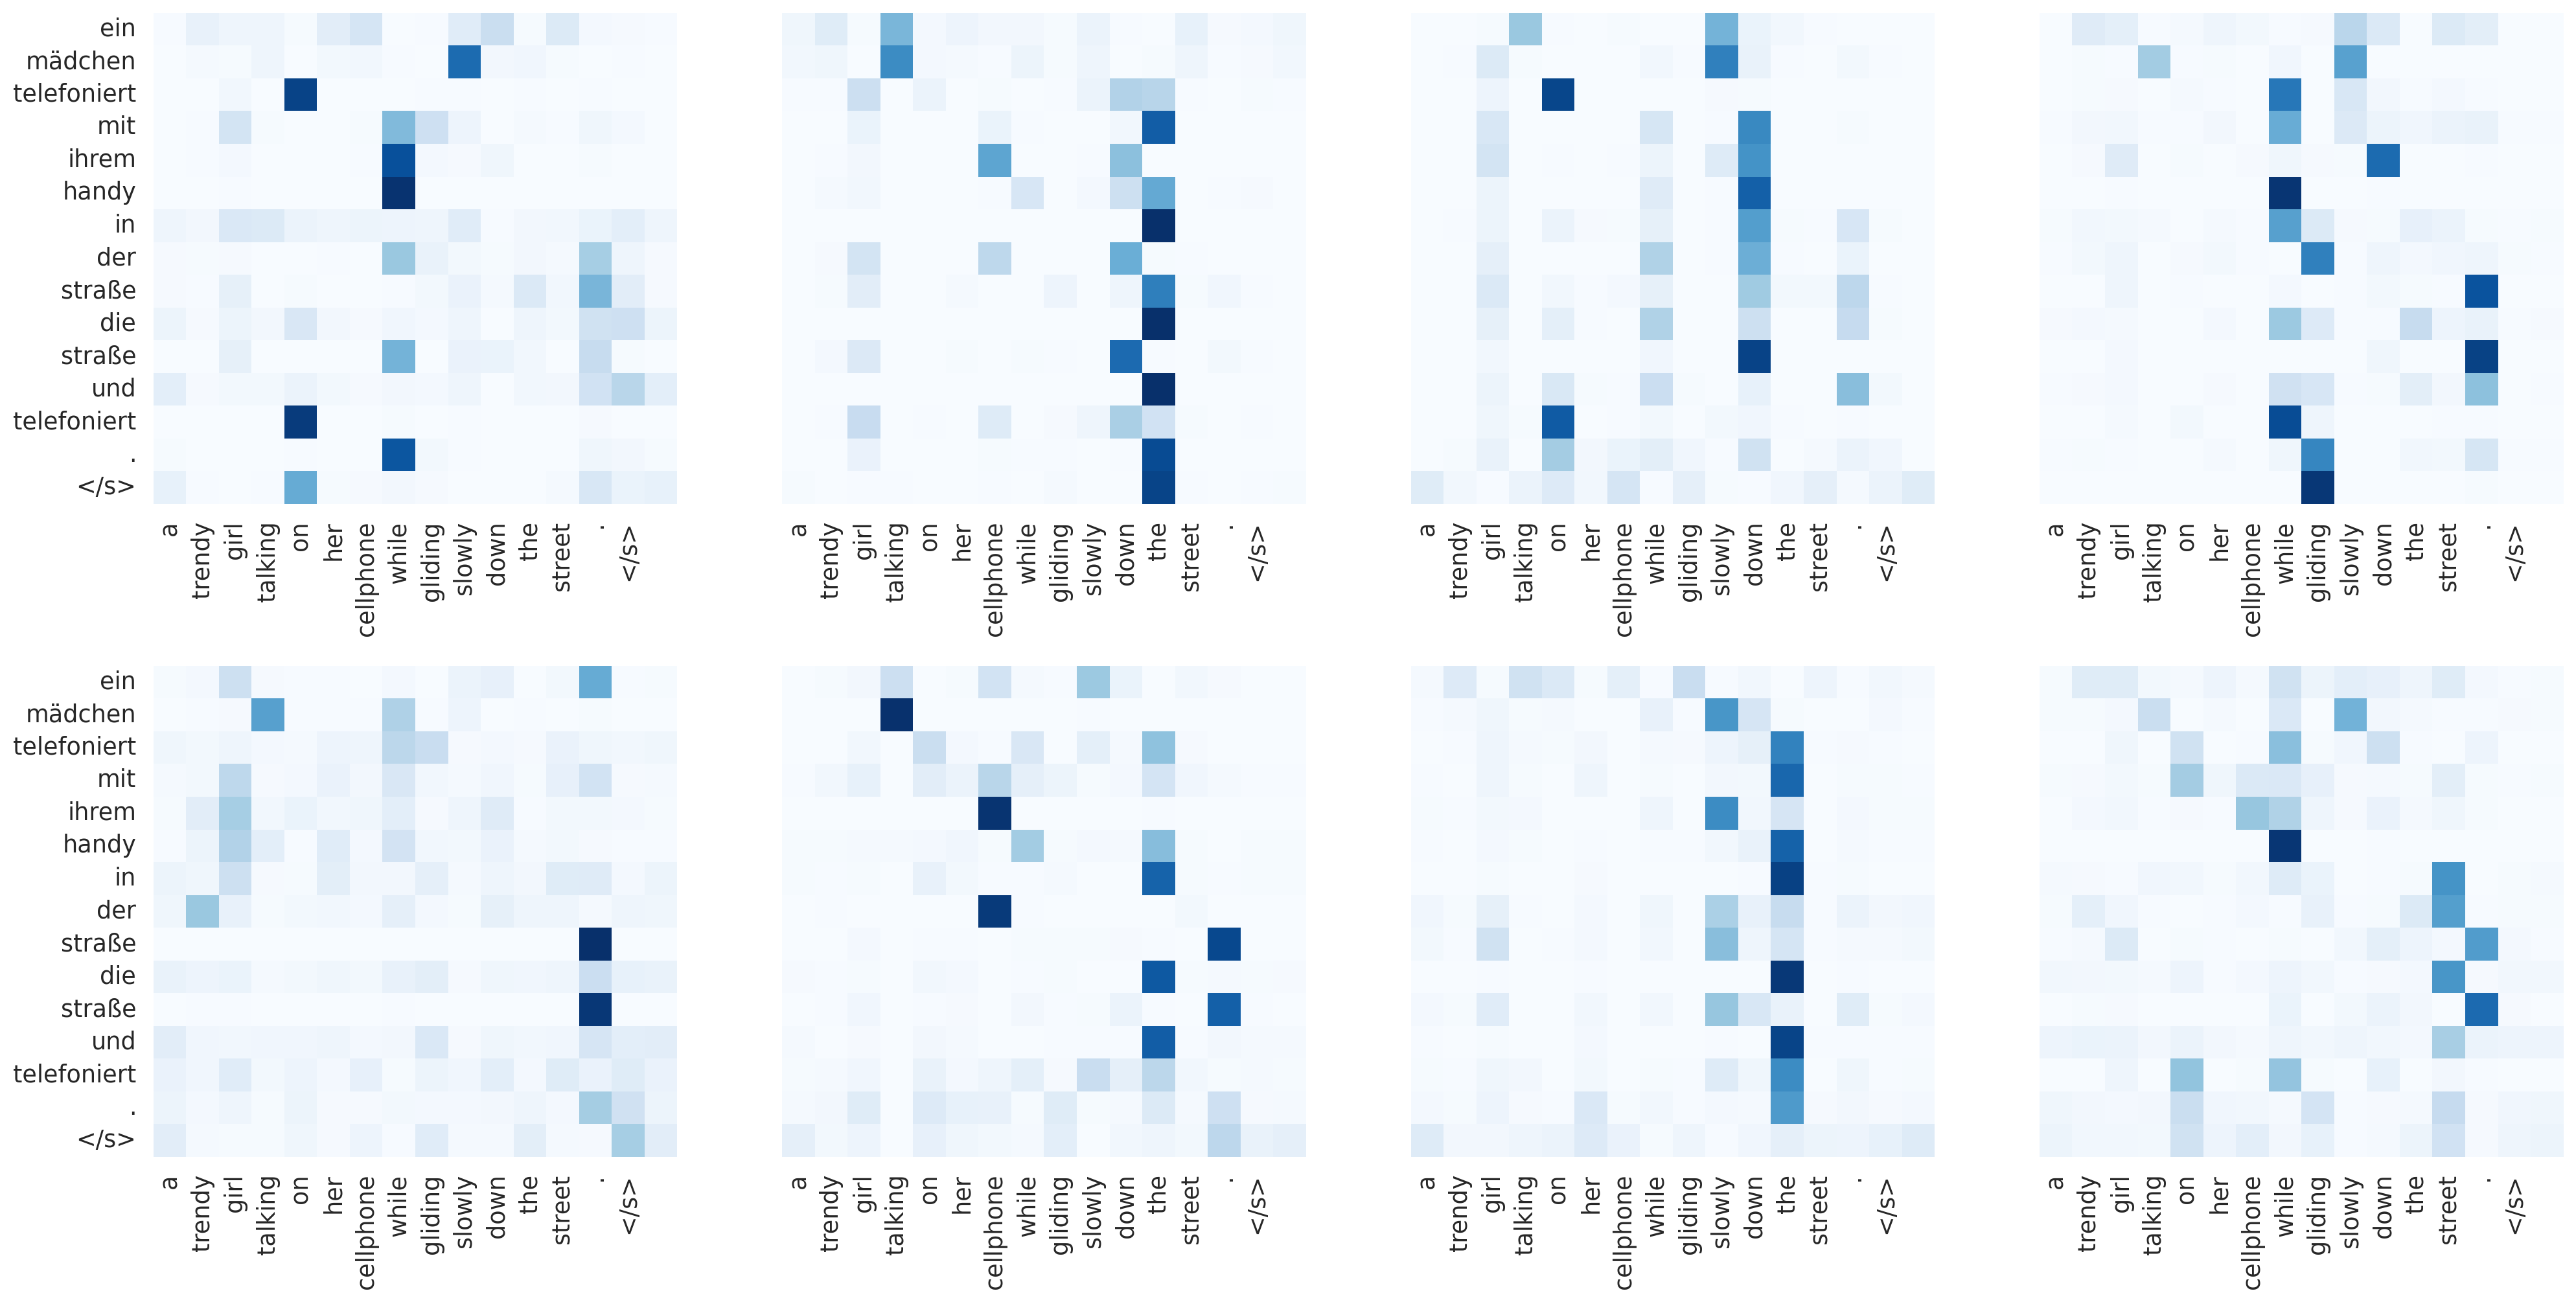

In [119]:
example_idx = 7

source = vars(train_data.examples[example_idx])['src']
target = vars(train_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

Each plot corresponds to one head, Plot represents attention weights(How much a german word to attend to each english word).
These attention weights are attention performed at last layer of decoder(between encoder_outputs and decoder inputs), and decoder at stage of generating last word in targret seq

source: ['construction', 'workers', 'standing', 'on', 'top', 'of', 'a', 'piece', 'of', 'machinery', '.']

target: ['bauarbeiter', 'stehen', 'auf', 'einer', 'maschine']

predicted: ['arbeiter', 'stehen', 'oben', 'auf', 'einer', 'maschine', '.', '</s>']



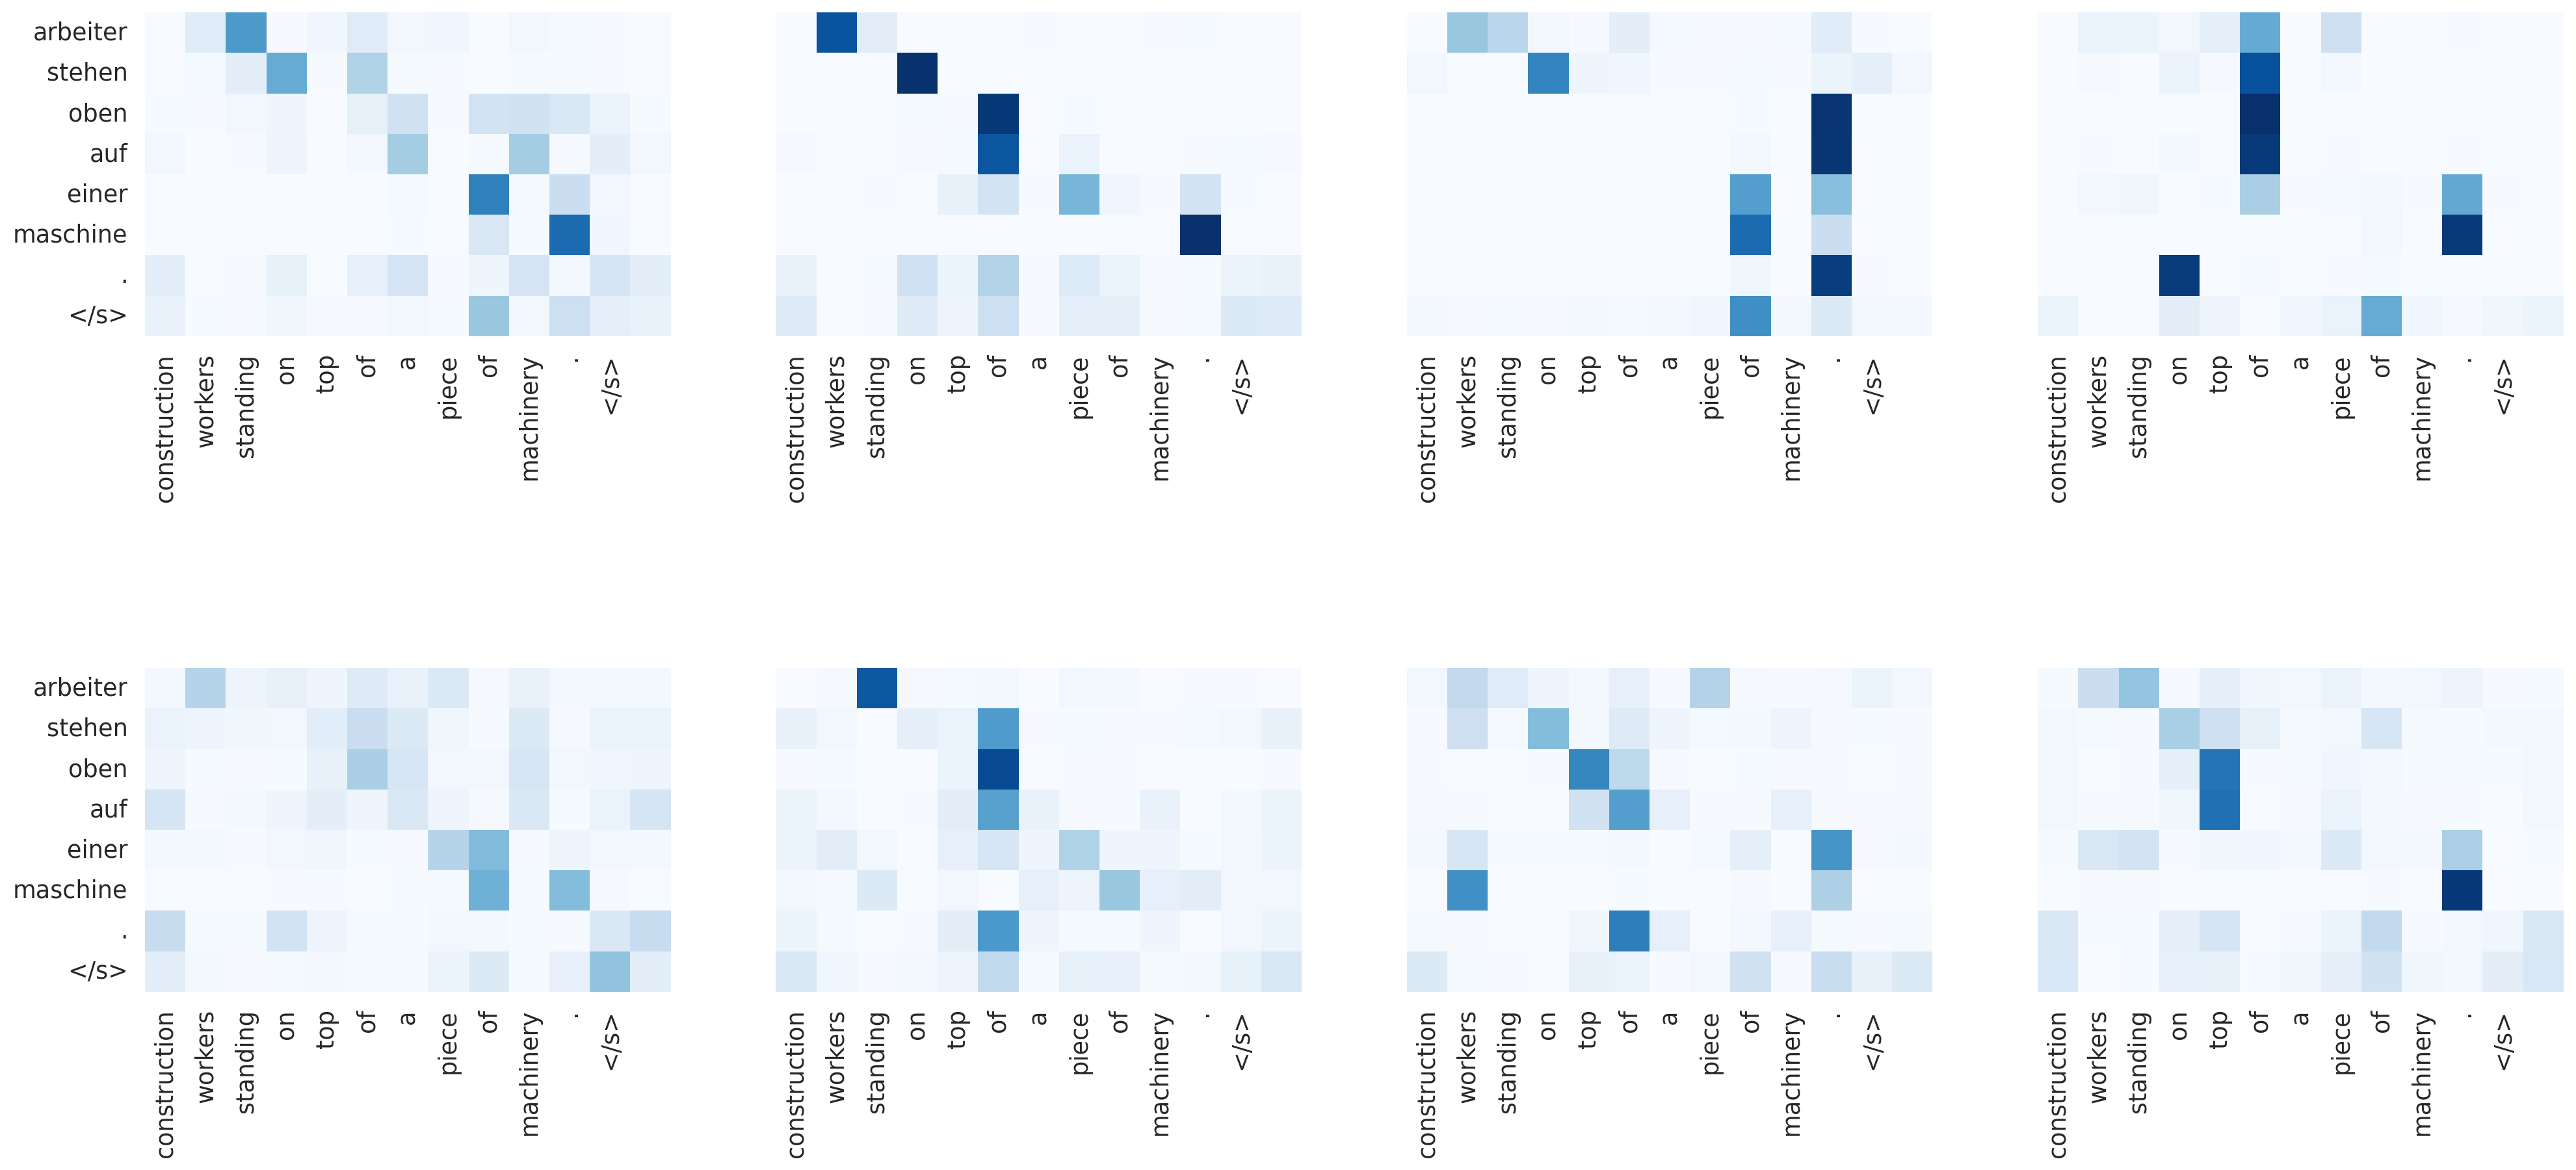

In [120]:
example_idx = 24

source = vars(valid_data.examples[example_idx])['src']
target = vars(valid_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

source: ['people', 'walking', 'down', 'sidewalk', 'next', 'to', 'a', 'line', 'of', 'stores', '.']

target: ['leute', 'gehen', 'auf', 'einem', 'gehsteig', 'neben', 'einer', 'reihe', 'von', 'geschäften', '.']

predicted: ['eine', 'reihe', 'von', 'menschen', 'geht', 'neben', 'mehreren', 'geschäften', 'entlang', '.', '</s>']



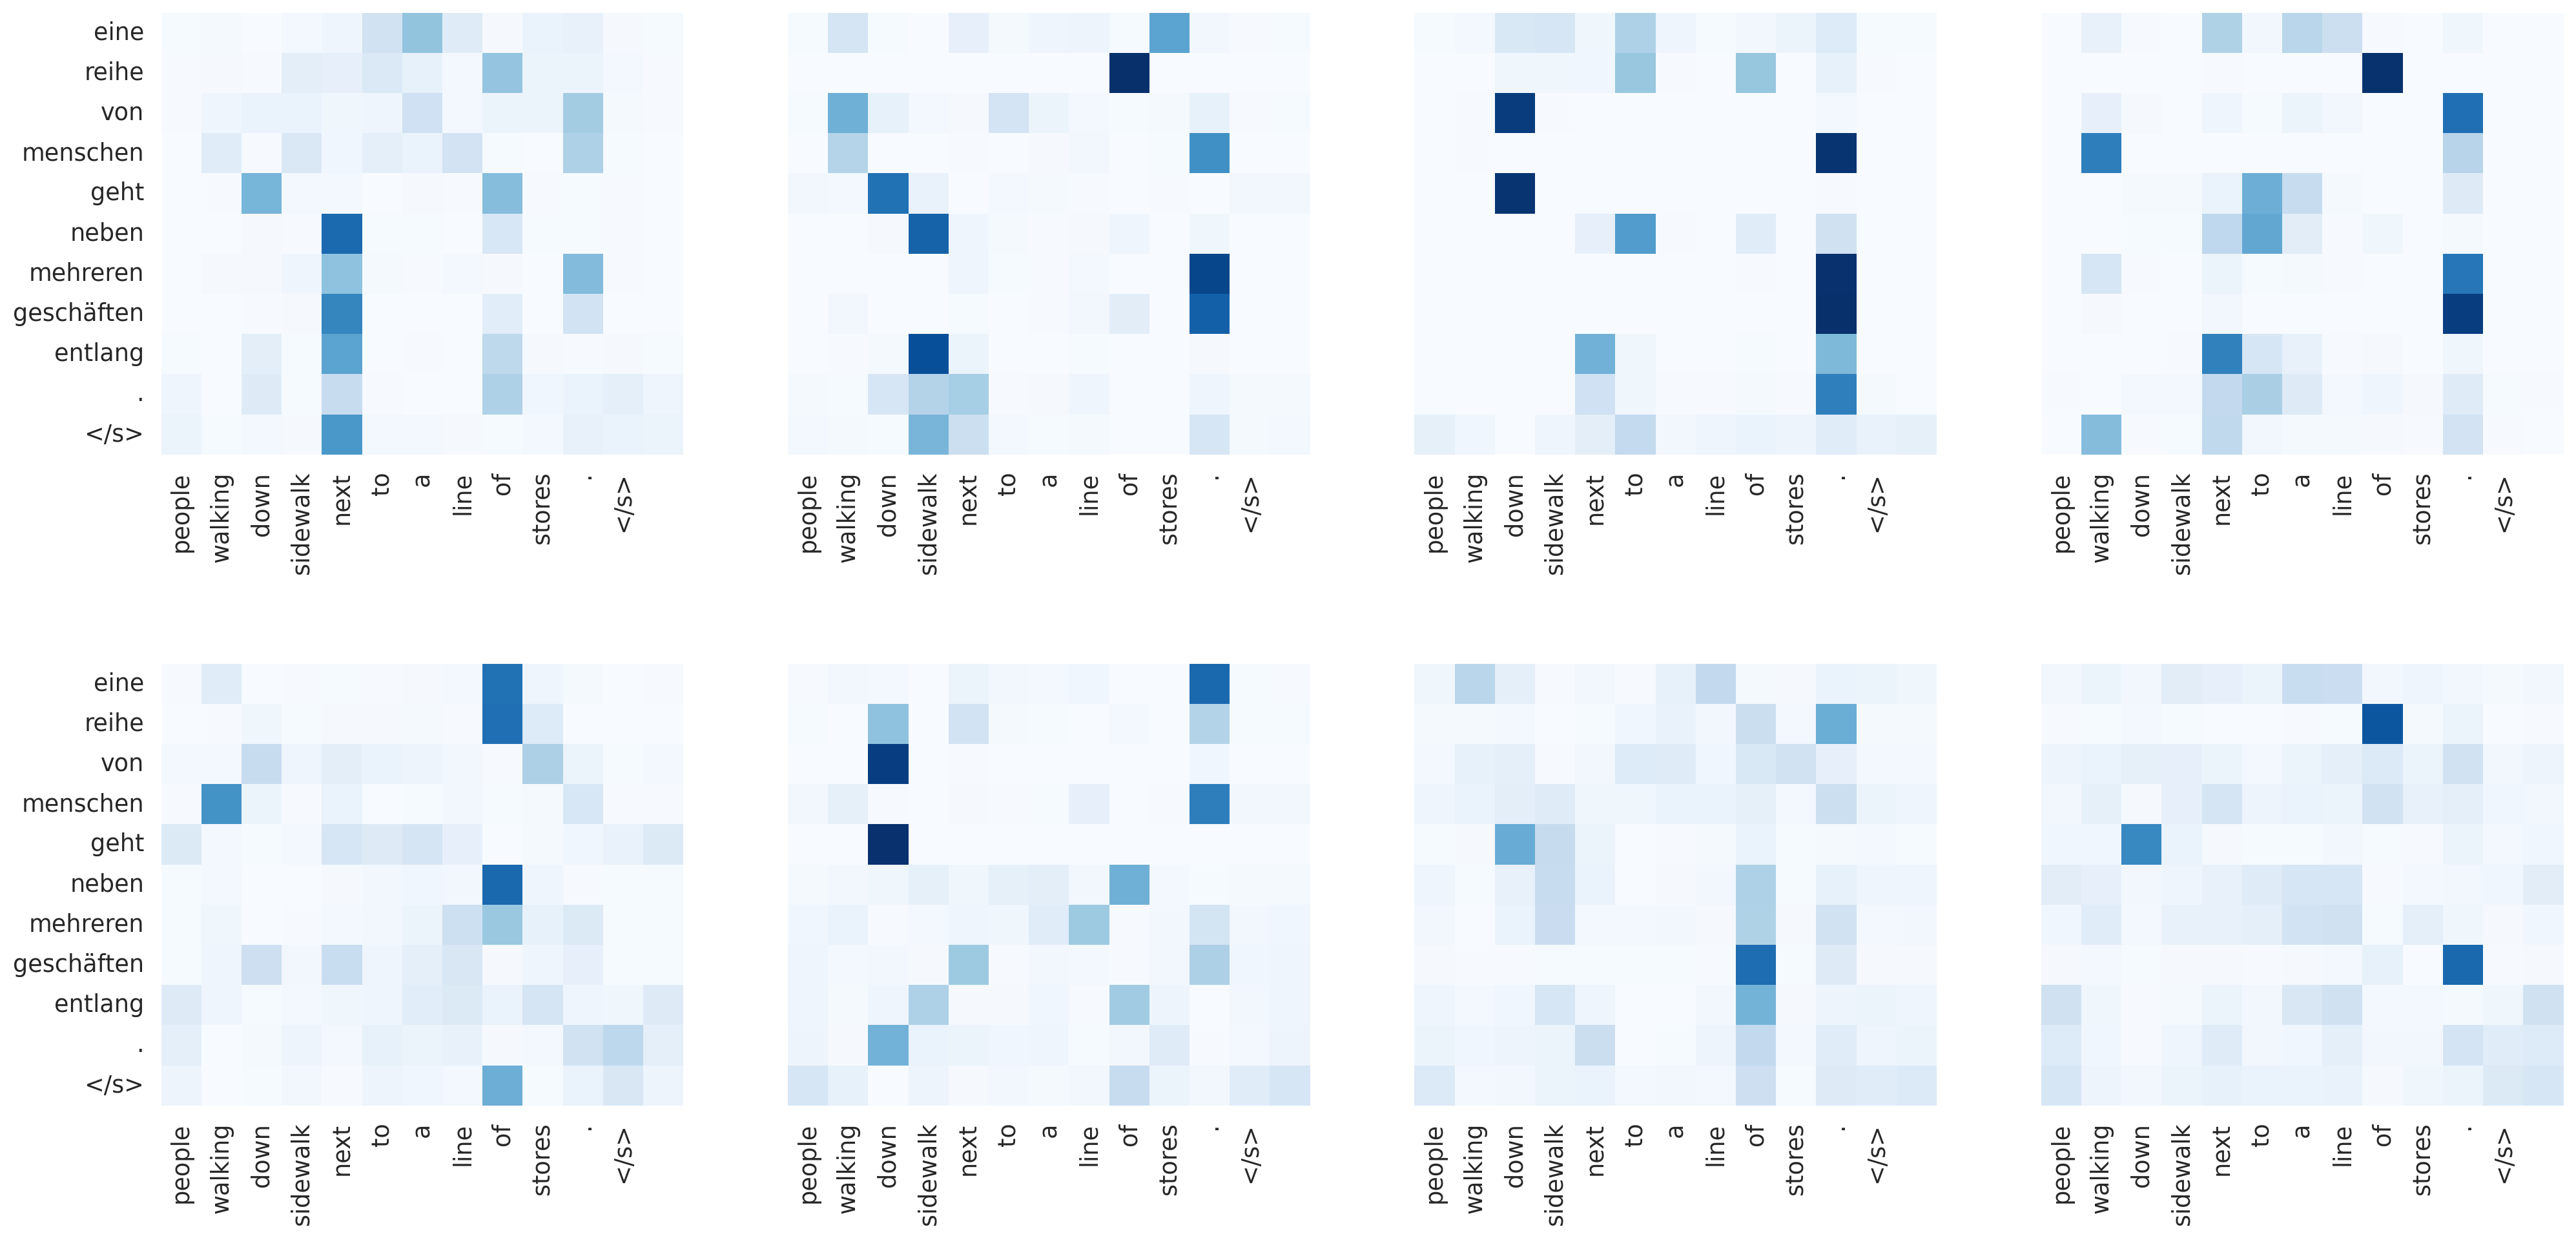

In [121]:
example_idx = 50

source = vars(test_data.examples[example_idx])['src']
target = vars(test_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

## References

1. [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
2. [Łukasz Kaiser’s talk on Attentional Neural Network](https://www.youtube.com/watch?v=rBCqOTEfxvg)
3. [The Illustrated Transformer by Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
4. [The Annotated Transformer by Harvard NLP Group](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
5. [Attention is all you need: A Pytorch Implementation by @jadore801120](https://github.com/jadore801120/attention-is-all-you-need-pytorch)
6. [PyTorch Seq2Seq by Ben Trevett](https://github.com/bentrevett/pytorch-seq2seq)
